coding: utf-8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from os import listdir
from itertools import combinations

## Data Wrangling<br>
1. Gather CSV files<br>
2. Load CSV file data into dataframes.<br>
3. Compile the dataframes into a dictionary. <br>
4. Inspect the data.

Data Wrangling Functions 

In [2]:
def find_csv_files (path_to_dir):
    """Return: List of filenames with suffix in path_to_dir."""
    return [filename for filename in listdir(path_to_dir) if filename.endswith( suffix )] 

In [3]:
def csv_dir_to_df_dict(path_to_dir):
    """Return dictionary of dataframes loaded with csv files in path_to_dir."""
    result_dict = {}
    
    for filename in find_csv_files(path_to_dir):
        # Include path with filename 
        fullname = ("{}/{}").format(path_to_dir, filename)
        
        # dataframe name = filename, trimmed of suffix.
        dfname = filename.rsplit(suffix)[0]
        
        result_dict[dfname] = pd.read_csv(fullname)
        
    return result_dict

In [4]:
def print_df_preview(dfname, df):
    """Print the first & last several rows & columns of a dataframe."""
    print('\n{}\n{} {} :\n\n{}' \
          .format("="*50, dfname, \
                df.shape, \
                df[list(df.columns[0:3]) + list(df.columns[-3:])].iloc[[0,1,-2,-1]] \
               )) 
    
    
def print_dfdict_preview(df_dict):
    """Print preview of dataframes within a dictionary."""
    print('\nHead & Tail of DataFrame rows & columns:\n')
    [print_df_preview(dfname, df) for dfname, df in df_dict.items()]
    

 Load CSV into `datasets_di`, a dictionary of dataframes, 1 dataframe for each CSV file.

Identify dataset by directory name, allow for more than 1

In [5]:
dataset_dir_list = ['Data']

Create dictionary of dataframes

In [6]:
suffix = '.csv'
datasets_di = {}
for dataset_path_to_dir in dataset_dir_list:
    datasets_di.update(csv_dir_to_df_dict(dataset_path_to_dir))

All data is now loaded into `datasets_di`.<br>
<br>
Let's preview the loaded data ...

Preview a few rows & columns of each dataframe. Include their shapes.

In [7]:
print_dfdict_preview(datasets_di)


Head & Tail of DataFrame rows & columns:


poverty_percent_people_below_550_a_day (163, 41) :

          geo  1977  1978  2014  2015  2016
0     Albania   0.0     0   0.0   0.0   NaN
1     Algeria   0.0     0   0.0   0.0   NaN
161    Zambia   0.0     0   0.0  87.2   NaN
162  Zimbabwe   0.0     0   0.0   0.0   NaN

income_per_person_gdppercapita_ppp_inflation_adjusted (193, 220) :

             geo  1800  1801   2016   2017   2018
0    Afghanistan   603   603   1740   1800   1870
1        Albania   667   667  11400  11900  12400
191       Zambia   663   665   3640   3750   3870
192     Zimbabwe   869   870   1860   1910   1950

surface_area_sq_km (194, 58) :

         country    1961    1962    2015    2016    2017
0    Afghanistan  653000  653000  653000  653000  653000
1        Albania   28800   28800   28800   28800   28800
192       Zambia  753000  753000  753000  753000  753000
193     Zimbabwe  391000  391000  391000  391000  391000

primary_completion_rate_total_percent_of_relev

Clean the datasets to make it ready for analysis ...

### Data Cleaning<br>
<br>
Before data cleaning starts:<br>
* Create a dataframe called `meta_df` to itemize the dataframes.<br>
* Simplify dataframe names.<br>
<br>
Then clean and trim as follows:<br>
<br>
 **Columns**<br>
 Each dataframe contains a row for each country, and a sequence of year<br>
 columns. Standardize the name of the country column to 'country' and <br>
 index on it.<br>
<br>
 **Zeros and NaN**<br>
 Zero values are assumed to be years in which a statistic for a <br>
 country was not gathered. Zeros can skew the data when calculating <br>
 aggregates. For this reason, reset zero values to NaN.<br>
<br>
 **Countries**<br>
 Not all dataframes contain the same set of countries.  Avoid <br>
attempting to draw correlation between country statistics when not all <br>
countries have recorded statistics by trimming dataframes so they share <br>
a common set of countries.<br>
<br>
 **Years**: Not all dataframes contain the same range of years. <br>
 Trim dataframes so they share a common range of years for consistent <br>
 analysis.

#### Metadata<br>
Create `meta_df` to itemize loaded datasets. 

Initialize meta_df with dataframe names

In [8]:
meta_df = pd.DataFrame([dfname for dfname in datasets_di.keys()], \
                       columns=['dataframe'])

Dataframes were named with CSV filenames, which are long and wordy. <br>
Create shorter aliases in `meta_df`.  

First, create an alias dictionary. Prompt user for each alias, offer a default ...

In [9]:
alias_di = {}

For each df, prompt for alias, default = first word delimited by underscore

In [10]:
print('\nEnter alias for each dataframe (press enter to accept default):\n')
for dfname in datasets_di.keys():
    this_alias = '_'.join(dfname.split('_', 2)[:2])
    this_alias = input('{}: ({})'.format(dfname, this_alias)) or this_alias
    alias_di[dfname] = this_alias
    #print('"'+'\n"'.join(str(dfname)+'":"'+str(dfname).split("_")[0]+'",'))


Enter alias for each dataframe (press enter to accept default):

poverty_percent_people_below_550_a_day: (poverty_percent)
income_per_person_gdppercapita_ppp_inflation_adjusted: (income_per)
surface_area_sq_km: (surface_area)
primary_completion_rate_total_percent_of_relevant_age_group: (primary_completion)
life_expectancy_years: (life_expectancy)
total_water_withdrawal_billion_cu_meters: (total_water)
hdi_human_development_index: (hdi_human)
murder_per_100000_people: (murder_per)
murder_total_deaths: (murder_total)
se_prm_tenr: (se_prm)
population_density_per_square_km: (population_density)
population_total: (population_total)
at_least_basic_water_source_overall_access_percent: (at_least)
armed_forces_personnel_percent_of_labor_force: (armed_forces)
er_h2o_fwst_zs: (er_h2o)


In [11]:
print(alias_di)

{'poverty_percent_people_below_550_a_day': 'poverty_percent', 'income_per_person_gdppercapita_ppp_inflation_adjusted': 'income_per', 'surface_area_sq_km': 'surface_area', 'primary_completion_rate_total_percent_of_relevant_age_group': 'primary_completion', 'life_expectancy_years': 'life_expectancy', 'total_water_withdrawal_billion_cu_meters': 'total_water', 'hdi_human_development_index': 'hdi_human', 'murder_per_100000_people': 'murder_per', 'murder_total_deaths': 'murder_total', 'se_prm_tenr': 'se_prm', 'population_density_per_square_km': 'population_density', 'population_total': 'population_total', 'at_least_basic_water_source_overall_access_percent': 'at_least', 'armed_forces_personnel_percent_of_labor_force': 'armed_forces', 'er_h2o_fwst_zs': 'er_h2o'}


Map the dataframe aliases to `meta_df` dataframe names and index on it.

In [12]:
meta_df['statistic'] = meta_df['dataframe'].map(alias_di)
meta_df.set_index('statistic', inplace=True)
meta_df

,dataframe
statistic,
poverty_percent,poverty_percent_people_below_550_a_day
income_per,income_per_person_gdppercapita_ppp_inflation_a...
surface_area,surface_area_sq_km
primary_completion,primary_completion_rate_total_percent_of_relev...
life_expectancy,life_expectancy_years
total_water,total_water_withdrawal_billion_cu_meters
hdi_human,hdi_human_development_index
murder_per,murder_per_100000_people
murder_total,murder_total_deaths


***<br>
Now rename dataframes using the aliases ...

List original dataframe names

In [13]:
dflist = list(datasets_di.keys())

rename dataframes with their statistic name (mapped in meta_df)

In [14]:
for df in dflist:
    datasets_di[meta_df[meta_df['dataframe'] == df].index[0]] = datasets_di.pop(df)

Verify new dataframe (statistic) names

In [15]:
list(datasets_di.keys())

['poverty_percent',
 'income_per',
 'surface_area',
 'primary_completion',
 'life_expectancy',
 'total_water',
 'hdi_human',
 'murder_per',
 'murder_total',
 'se_prm',
 'population_density',
 'population_total',
 'at_least',
 'armed_forces',
 'er_h2o']

***<br>
Data structures are ready. Start cleaning ...

#### Columns - Rename and Index<br>
Standardize all dataframe Country columns to 'country', and make it the row index.

function to rename/reindex

In [16]:
f = lambda df: (df.rename(columns={'geo':'country'}).set_index('country'))

In [17]:
for dfname in list(datasets_di.keys()):
    datasets_di[dfname] = f(datasets_di[dfname])

Confirm all indexes are 'country' <br>
TODO: add error handling procedures

In [18]:
print('Are all dataframe indexes named "country"?')
'country' == np.unique(list(map(lambda k: datasets_di[k].index.name, (k for k in datasets_di.keys()))))[0]

Are all dataframe indexes named "country"?


True

Backup datasets_di before trimming

In [19]:
datasets_di_backup = datasets_di.copy()

#### Zeros and NaN - Cleanup<br>
Any Zero values are assumed to be placeholders for missing data. <br>
Since zero values can inadvertently skew aggregate calculations, <br>
reset them to NaN (null).<br>
<br>
Afterwards, make sure there are now no rows completely empty.

Functions for Cleanup

In [20]:
def print_zeros(dfname, df):
    """Return False if no zeros, True of any are found. Print columns and rows with Zero values."""
    result = False
    zero_count = (df[df.columns]==0).any(axis=1).sum()
    if zero_count:
        print('\n{}\n{}:'.format('='*50, dfname))
        print('{}\n'.format(df[df.isin([0]).any(axis=1)]))
        result = True
    return result
            

In [21]:
def print_if_all_nulls(df_dict):
    """Return None. Print report, listing any dataframes that have rows containing only null values."""
    found = False
    for dfname, df in datasets_di.items():
        if pd.isnull(df).all(1).any():
            print('{} has row with all nulls.'.format(dfname))
            found = True
    if not found:
        print('No empty rows.')
    
    return None

Print any Zero values ...

In [22]:
print('DataFrame Rows with Zero Values:')
[print_zeros(dfname, df) for dfname, df in datasets_di.items()];

DataFrame Rows with Zero Values:

poverty_percent:
                          1977  1978  1979  1980  1981  1982  1983  1984  \
country                                                                    
Albania                    0.0     0   0.0   0.0   0.0   0.0   0.0   0.0   
Algeria                    0.0     0   0.0   0.0   0.0   0.0   0.0   0.0   
Angola                     0.0     0   0.0   0.0   0.0   0.0   0.0   0.0   
Argentina                  0.0     0   0.0   1.7   0.0   0.0   0.0   0.0   
Armenia                    0.0     0   0.0   0.0   0.0   0.0   0.0   0.0   
Australia                  0.0     0   0.0   0.0   1.7   0.0   0.0   0.0   
Austria                    0.0     0   0.0   0.0   0.0   0.0   0.0   0.0   
Azerbaijan                 0.0     0   0.0   0.0   0.0   0.0   0.0   0.0   
Bangladesh                 0.0     0   0.0   0.0   0.0   0.0  96.2   0.0   
Belarus                    0.0     0   0.0   0.0   0.0   0.0   0.0   0.0   
Belgium                    0.0     0 

                           1990   1991   1992   1993   1994    1995    1996  \
country                                                                       
Afghanistan               1.770  1.290  1.200  1.110  1.030   8.270   8.930   
Albania                   0.000  0.000  4.560  4.630  4.700   6.370   4.990   
Armenia                   0.000  0.000  1.410  1.510  3.330   4.610   4.470   
Azerbaijan                0.000  0.000  1.420  1.450  1.570   3.900   3.360   
Bahamas                   0.000  0.000  0.000  0.000  0.000   1.450   2.180   
Barbados                  0.000  0.000  0.000  0.000  0.000   0.418   0.420   
Belarus                   0.000  0.000  2.180  2.450  1.380   2.250   1.980   
Benin                     0.307  0.346  0.334  0.367  0.354   0.311   0.302   
Bhutan                    0.000  0.000  2.640  2.700  2.750   2.220   2.720   
Bosnia and Herzegovina    0.000  0.000  3.580  0.000  4.500   6.090  15.300   
Burkina Faso              0.259  0.252  0.223  0.218

Translate all Zeros into NaNs ...<br>
Replace zeros with NaN, then drop any rows where all values are NaN. 

In [23]:
for dfname, df in datasets_di.items():
    datasets_di[dfname] = datasets_di[dfname].replace({0:np.nan, 0.0:np.nan})
    datasets_di[dfname] = datasets_di[dfname].dropna(how='all')

Verify there are no empty rows.

In [24]:
print_if_all_nulls(datasets_di)

No empty rows.


TODO: more error handling here ... handle any non-empty rows.<br>
<br>
Start trimming ...

#### Countries - Trim<br>
Make sure dataframes share a common set of countries (inner join) by<br>
trimming any countries not shared by all dataframes.<br>
<br>
First, identify the countries to be trimmed and list them in `meta_df` for reference.<br>
Create list of common countries.

In [25]:
dflist = list(datasets_di.values())
common_countries_list = pd.concat(dflist, axis=1, join='inner').index

Add uncommon countries (to be trimmed) to meta_df.

In [26]:
meta_df['excluded_countries'] = ""
for data_set, df in datasets_di.items():
    meta_df.loc[data_set]['excluded_countries'] = [x for x in df.index if x not in common_countries_list]
    
# View the countries to be excluded.
pd.set_option('display.max_colwidth', -1)
meta_df

,dataframe,excluded_countries
statistic,,
poverty_percent,poverty_percent_people_below_550_a_day,"[Algeria, Angola, Australia, Bangladesh, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Burkina Faso, Burundi, Cameroon, Cape Verde, Central African Republic, Chad, China, Comoros, Congo, Dem. Rep., Congo, Rep., Cote d'Ivoire, Czech Republic, Djibouti, Ethiopia, Fiji, Gabon, Gambia, Ghana, Guinea, Guinea-Bissau, Haiti, Honduras, India, Indonesia, Iran, Iraq, Kenya, Kiribati, Lao, Lebanon, Lesotho, Liberia, Madagascar, Malawi, Maldives, Mali, Mauritania, Micronesia, Fed. Sts., Montenegro, Morocco, Mozambique, Myanmar, Namibia, Nepal, Niger, Nigeria, Pakistan, Palestine, Papua New Guinea, Paraguay, Rwanda, Samoa, Senegal, Seychelles, Sierra Leone, Slovak Republic, Solomon Islands, South Sudan, St. Lucia, Sudan, Swaziland, Syria, Tanzania, Timor-Leste, Togo, Tonga, Turkmenistan, Tuvalu, Uganda, United States, Vanuatu, Vietnam, Yemen, Zambia, Zimbabwe]"
income_per,income_per_person_gdppercapita_ppp_inflation_adjusted,"[Afghanistan, Algeria, Andorra, Angola, Antigua and Barbuda, Australia, Bahamas, Bahrain, Bangladesh, Barbados, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brunei, Burkina Faso, Burundi, Cambodia, Cameroon, Cape Verde, Central African Republic, Chad, China, Comoros, Congo, Dem. Rep., Congo, Rep., Cote d'Ivoire, Cuba, Czech Republic, Djibouti, Dominica, Equatorial Guinea, Eritrea, Ethiopia, Fiji, Gabon, Gambia, Ghana, Grenada, Guinea, Guinea-Bissau, Haiti, Honduras, India, Indonesia, Iran, Iraq, Kenya, Kiribati, Kuwait, Lao, Lebanon, Lesotho, Liberia, Libya, Madagascar, Malawi, Maldives, Mali, Marshall Islands, Mauritania, Micronesia, Fed. Sts., Monaco, Montenegro, Morocco, Mozambique, Myanmar, Namibia, Nauru, Nepal, New Zealand, Niger, Nigeria, North Korea, Oman, Pakistan, Palau, Palestine, Papua New Guinea, Paraguay, Qatar, Rwanda, Samoa, San Marino, Saudi Arabia, Senegal, Seychelles, Sierra Leone, Singapore, Slovak Republic, Solomon Islands, Somalia, South Sudan, St. Kitts and Nevis, St. Lucia, St. Vincent and the Grenadines, Sudan, Swaziland, Syria, ...]"
surface_area,surface_area_sq_km,"[Afghanistan, Algeria, Andorra, Angola, Antigua and Barbuda, Australia, Bahamas, Bahrain, Bangladesh, Barbados, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brunei, Burkina Faso, Burundi, Cambodia, Cameroon, Cape Verde, Central African Republic, Chad, China, Comoros, Congo, Dem. Rep., Congo, Rep., Cote d'Ivoire, Cuba, Czech Republic, Djibouti, Dominica, Equatorial Guinea, Eritrea, Ethiopia, Fiji, Gabon, Gambia, Ghana, Grenada, Guinea, Guinea-Bissau, Haiti, Honduras, India, Indonesia, Iran, Iraq, Kenya, Kiribati, Kuwait, Lao, Lebanon, Lesotho, Liberia, Libya, Liechtenstein, Madagascar, Malawi, Maldives, Mali, Marshall Islands, Mauritania, Micronesia, Fed. Sts., Monaco, Montenegro, Morocco, Mozambique, Myanmar, Namibia, Nauru, Nepal, New Zealand, Niger, Nigeria, North Korea, Oman, Pakistan, Palau, Palestine, Papua New Guinea, Paraguay, Qatar, Rwanda, Samoa, San Marino, Saudi Arabia, Senegal, Seychelles, Sierra Leone, Singapore, Slovak Republic, Solomon Islands, Somalia, South Sudan, St. Kitts and Nevis, St. Lucia, St. Vincent and the Grenadines, Sudan, Swaziland, ...]"
primary_completion,primary_completion_rate_total_percent_of_relevant_age_group,"[Afghanistan, Algeria, Angola, Antigua and Barbuda, Bahamas, Bahrain, Bangladesh, Barbados, Benin, Bhutan, Bolivia, Botswana, Brunei, Burkina Faso, Burundi, Cambodia, Cameroon, Cape Verde, Central African Republic, Chad, China, Comoros, Congo, Dem. Rep., Congo, Rep., Cote d'Ivoire, Cuba, Czech Republic, Djibouti, Dominica, Equatorial Guinea, Eritrea, Ethiopia, Fiji, Gabon, Gambia, Ghana, Grenada, Guinea, Guinea-Bissau, Haiti, Honduras, India, Indonesia, Iran, Iraq, Kenya, Kiribati, Kuwait, Lao, Lebanon, Lesotho, Liberia, Libya, Liechtenstein, Madagascar, Malawi, Maldives, Mali, Marshall Islands, Mauritania, Montenegro, Morocco, Mozambique, Myanmar, Namibia

***<br>
TODO: add functionality to verify with the analyst that the above <br>
list is acceptable before trimming excluded countries.<br>
<br>
Exclude non-common countries from dataframes.

In [27]:
for dfname, df in datasets_di.items():
    datasets_di[dfname] = df[df.index.isin(common_countries_list)]

Verify dataframe row counts match (confirming the same number of countries).

In [28]:
[print(df.shape[0], dfname) for dfname, df in datasets_di.items()];

79 poverty_percent
79 income_per
79 surface_area
79 primary_completion
79 life_expectancy
79 total_water
79 hdi_human
79 murder_per
79 murder_total
79 se_prm
79 population_density
79 population_total
79 at_least
79 armed_forces
79 er_h2o


TODO: more automated exception handling here, verify working with a uniform set of countries. <br>
<br>
Trim year columns ...

#### Years - Trim<br>
Verify a consistent range of years by finding a common range of years and trimming the rest.

Functions for Trimming

In [29]:
def get_year_metadata(dict):
    """Return dataframe containing range of years."""
    result_df = pd.DataFrame()
    for dfname, df in dict.items():
        result_df[dfname] = [df.columns[0], df.columns[-1]]
    result_df = result_df.transpose()   
    result_df.rename(columns = {0:'first_year',1:'last_year'}, inplace=True)
    result_df.index.names = ['data_set']
    return result_df

In [30]:
def trim_df_dict(df_dict, col_list):
    """Return dictionary of dataframes, trimmed of columns not in col_list."""
    result_dict = {}
    for dfname, df in df_dict.items():
        keep_columns = [col for col in df_dict[dfname].columns if col in col_list]
        result_dict[dfname] = df_dict[dfname][keep_columns]
        
    return result_dict

Before trimming years, record the original year ranges to `meta_df` <br>
for reference, and report the Common Year Range.

In [31]:
meta_df = pd.concat([meta_df, get_year_metadata(datasets_di)], axis=1)
meta_df[['first_year','last_year']]

,first_year,last_year
poverty_percent,1977,2016
income_per,1800,2018
surface_area,1961,2017
primary_completion,1970,2017
life_expectancy,1800,2018
total_water,1962,2016
hdi_human,1990,2015
murder_per,1950,2016
murder_total,1950,2016
se_prm,1970,2017


Find common range

In [32]:
first_year, last_year = (meta_df['first_year'].max(), meta_df['last_year'].min())

Confirm range of years

In [33]:
print('Common Year Range: {} -> {}\n'.format(first_year, last_year))

Common Year Range: 2014 -> 2015



TODO: more exception handling here.<br>
<br>
Trim the years outside the Common Year Range.

In [34]:
years_in_range = [str(y) for y in list(range(int(first_year),int(last_year)+1))]
datasets_di = trim_df_dict(datasets_di, years_in_range)

At this point, dataframes should have the same shape (country rows <br>
and year columns). Verify this ... (TODO: automate the verification)

Confirm trimmed datasets. Each dataset should have same year columns.

In [35]:
[print('{} <-- {}'.format(df.shape, dfname)) for dfname, df in datasets_di.items()];

(79, 2) <-- poverty_percent
(79, 2) <-- income_per
(79, 2) <-- surface_area
(79, 2) <-- primary_completion
(79, 2) <-- life_expectancy
(79, 2) <-- total_water
(79, 2) <-- hdi_human
(79, 2) <-- murder_per
(79, 2) <-- murder_total
(79, 2) <-- se_prm
(79, 2) <-- population_density
(79, 2) <-- population_total
(79, 2) <-- at_least
(79, 2) <-- armed_forces
(79, 2) <-- er_h2o


***<br>
Dataframes should now clean and trim. 

***<br>
## Correlation Analysis

*** <br>
Use `datasets_di` for these set of questions, since its dataframes <br>
have a consistent country list and range of years. <br>
<br>
Consider each dataset an individual 'factor'. <br>
<br>
TODO: make factor identification more flexible, such as multiple factors per dataset.

#### Prepare the data<br>
Create two new structures:<br>
* `dataset_stats` - dictionary of dataframes, similar to the <br>
  `datasets_di` dataframes but containing only the averages <br>
  for each country. (Includes averages of factor statistics. <br>
  TODO: drop if not needed.)

Create dataset_stats (dictionary of dataframes of with country means)

In [38]:
dataset_stats = {}
for dfname, df in datasets_di.items():
    dataset_stats[dfname] = df.transpose() \
                            .describe().loc[['mean']] \
                            .transpose()

Create 2D array, a row for each stat: <br>
  [[statistic name, statistic mean name]]

In [39]:
stats_arr = np.array([(stat, stat+"_mean") for stat in meta_df.index])
stats_arr

array([['poverty_percent', 'poverty_percent_mean'],
       ['income_per', 'income_per_mean'],
       ['surface_area', 'surface_area_mean'],
       ['primary_completion', 'primary_completion_mean'],
       ['life_expectancy', 'life_expectancy_mean'],
       ['total_water', 'total_water_mean'],
       ['hdi_human', 'hdi_human_mean'],
       ['murder_per', 'murder_per_mean'],
       ['murder_total', 'murder_total_mean'],
       ['se_prm', 'se_prm_mean'],
       ['population_density', 'population_density_mean'],
       ['population_total', 'population_total_mean'],
       ['at_least', 'at_least_mean'],
       ['armed_forces', 'armed_forces_mean'],
       ['er_h2o', 'er_h2o_mean']], dtype='<U23')

Find the correlation between every pair of factor statistics. First, create the pairings ...<br>
Create tuple pairs of all our statistic (dataframe) combinations.

In [40]:
stat_list = list(datasets_di.keys())
dataset_corrs = pd.DataFrame(columns=['size','this_stat','that_stat','r'])
combines = list(combinations(stat_list,2))

Now calculate the correlaltion coefficients ('r') for each pair ...<br>
Compute correlation coefficients against each statistic pair.

In [41]:
for stat_tuple in combines:
    this_stat = stat_tuple[0] 
    that_stat = stat_tuple[1]
    this_mean = dataset_stats[this_stat]['mean']
    that_mean = dataset_stats[that_stat]['mean']
    
    correlation = this_mean.corr(that_mean)
    dataset_corrs = dataset_corrs.append({'size':'all', \
                                          'this_stat':this_stat, \
                                          'that_stat':that_stat,  \
                                          'r':correlation  \
                                          }, \
                                          ignore_index=True \
                                         )  
        

Filter moderate-to-strong correlations.

In [42]:
dataset_corrs = dataset_corrs[abs(dataset_corrs['r']) > .4].sort_values(by=['r']).reset_index(drop=True)
print(dataset_corrs)

   size           this_stat         that_stat         r
0   all  poverty_percent     hdi_human        -0.829486
1   all  total_water         at_least         -0.684309
2   all  poverty_percent     life_expectancy  -0.639576
3   all  poverty_percent     income_per       -0.639418
4   all  life_expectancy     murder_per       -0.631927
5   all  poverty_percent     at_least         -0.624930
6   all  murder_per          at_least         -0.609265
7   all  hdi_human           murder_per       -0.482689
8   all  income_per          murder_per       -0.407742
9   all  life_expectancy     se_prm            0.433674
10  all  armed_forces        er_h2o            0.450661
11  all  income_per          se_prm            0.459754
12  all  poverty_percent     total_water       0.495791
13  all  income_per          at_least          0.557031
14  all  hdi_human           se_prm            0.563757
15  all  surface_area        population_total  0.570781
16  all  primary_completion  se_prm            0

Visualize the pairings with a graph

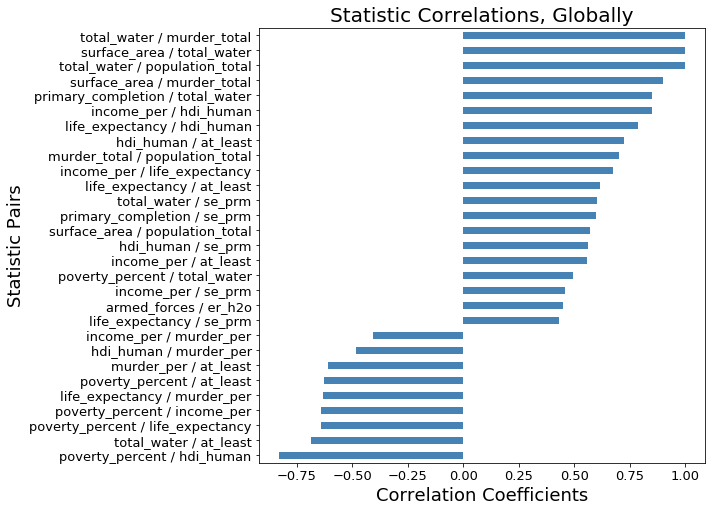

In [43]:
df = dataset_corrs[dataset_corrs['size'] == 'all']
x = df['r']
y = df['this_stat'].astype(str) + ' / ' + df['that_stat'].astype(str)
data = pd.concat([x,y], axis=1).set_index(0).rename_axis('this/that')
ax = data['r'].plot(kind='barh',fontsize=13, color='steelblue',figsize=(8,8));
ax.set_title("Statistic Correlations, Globally", fontsize=20, color='black')
ax.set_xlabel("Correlation Coefficients", fontsize=18, color='black')
ax.set_ylabel("Statistic Pairs", fontsize=18, color='black');
plt.show()

***